# Arbitrary Angle ZZ Gates via pytket

This notebook contains a comparison of circuits with and without use of Quantinuum's native arbitrary-angle ZZ gate in `pytket`.

* [Arbitrary Angle ZZ Gates](#arb-zz)
* [Quantum Fourier Transform](#qft)
* [QFT with Fixed Angle Gates](#qft-fixed)
* [QFT with Arbitrary Angle ZZ Gates](#qft-arb-zz)
* [Compare Results](#compare)

## Arbitrary Angle ZZ Gates <a class="anchor" id="arb-zz"></a>

Quantinuum System Model H1's native gate set includes arbitrary angle ZZ gates. This is beneficial for reducing the 2-qubit gate count for many quantum algorithms and gate sequences.

$$RZZ(\theta) = e^{-i\frac{\theta}{2}\hat{Z} \otimes \hat{Z}}= e^{-i \frac{\theta}{2}} \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & e^{-i\theta} & 0 & 0\\ 0 & 0 & e^{-i\theta} & 0\\ 0 & 0 & 0 & 1 \end{bmatrix}$$
<br>

Note that $RZZ(\frac{\pi}{2}) = ZZ()$.

Quantum circuits that use the gate sequence CNOT, RZ, CNOT can be replaced with the arbitrary angle ZZ gate, shown below. This enables a lower number of 2-qubit gates in a quantum circuit, improving performance by decreasing gate errors.

<br>

<div>
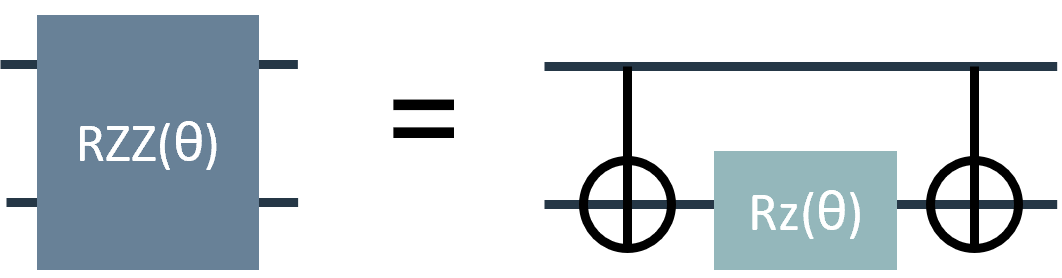
</div>

This notebook demonstrates the Quantum Fourier Transform (QFT) with and without the $RZZ$ gate.

## Quantum Fourier Transform <a class="anchor" id="qft"></a>

The Quantum Fourier Transform (QFT) is an algorithm that serves as a sub-routine in multiple quantum algorithms, including Shor's factoring algorithm. Below are two functions, written in `pytket`, that work together to implement the QFT. 

The `QFT` function can be used to create the QFT. It takes the following arguments:
- `n`: number of qubits to use in the QFT circuit
- `arbZZ`: specify whether to use the arbitrary-angle ZZ gate or not, `True`/`False`, default: `False`
- `approx`: if set to integer `k`, then controlled rotations by angles less than $\frac{\pi}{2}^{k}$ do not occur

**Note:** In many presentations of the QFT, the circuit includes a round of SWAP gates at the end of the circuit that reverses the order of the qubits. The QFT circuits in this tutorial do not include this final SWAP step.

**Note:** In `pytket` the $RZZ$ gate is implemented with the $ZZPhase$ circuit function.

In [1]:
import numpy as np
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

def control_phase(circ, theta, q0, q1, arbZZ=False):
    """ circuit gadget for performing controlled-[1 0;0 e^i theta]
        
        Inputs:
            circ: pytket Circuit object
            theta: Z rotation angle (in units of pi)
            q0: control qubit
            q1: target qubit
            arbZZ (bool): enables arbitrary angle RZZ gate
    """
    
    if arbZZ == False:
        # decompose into CNOTs
        circ.Rz(theta/2, q1) 
        circ.CX(q0, q1)
        circ.Rz(-theta/2, q1)
        circ.CX(q0, q1)
        circ.Rz(theta/2, q0)
    
    elif arbZZ == True:
        circ.Rz(theta/2, q0)
        circ.Rz(theta/2, q1)
        if theta > 0:
            circ.X(q0)
            circ.ZZPhase(theta/2, q0, q1)
            circ.X(q0)
        elif theta <= 0:
            circ.ZZPhase(-theta/2, q0, q1)

def QFT(n, **kwargs):
    """
        Function to implement the Quantum Fourier Transform
    
        n : number of qubits
        approx: if set to integer k, then sets that largest
                     value of pi/2**k occuring in controlled rotation
        returns circ: pytket Circuit object
    """
    
    # optional keyword arguments   
    arbZZ = kwargs.get('arbZZ', False)
    approx = kwargs.get('approx', None)
    
    # initialize
    circ_name = 'QFT-arbZZ' if arbZZ else 'QFT-fixed'
    circ = Circuit(n, n, name=circ_name)
    
    for j in range(n-1):
        q = n-1-j
        circ.H(q)
        for i in range(j+1):
            if approx == None or approx >= j+1-i:
                control_phase(circ, 1/(2**(j+1-i)), q-1, n-1-i,
                    arbZZ=arbZZ)
    circ.H(0)
    
    return circ

## QFT with Fixed Angle Gates <a class="anchor" id="qft-fixed"></a>

First, create the circuit with fixed-angle gates.

**Note**: `pytket` renders circuits in ZX-calculus notation. This can be toggled on and off by pressing the top left button.

In [2]:
n_qubits = 12

qft_fixed = QFT(n_qubits, arbZZ=False)

render_circuit_jupyter(qft_fixed)

## QFT with Arbitrary Angle ZZ Gates <a class="anchor" id="qft-arb-zz"></a>

Second, create the circuit with arbitrary-angle ZZ gates.

In [3]:
qft_arbZZ = QFT(n_qubits, arbZZ=True)

render_circuit_jupyter(qft_arbZZ)

## Compare Results <a class="anchor" id="compare"></a>

Now we compare the results of the QFT circuits with and without use of the arbitrary-angle ZZ gates on hardware.

### State Fidelity

The QFT circuit applied to the computational basis state $|x\rangle$ creates the state

\begin{align}
QFT|x\rangle&=\frac{1}{\sqrt{d}}\sum_{y=0}^{d-1} e^{2\pi i x y/d} |y\rangle\\
&= \bigotimes_{j=0}^{n-1}\frac{1}{\sqrt{2}}\sum_{y_j=0}^1e^{2\pi i x y_j/d}|y_j\rangle\\
&= \bigotimes_{j=0}^{n-1}\frac{1}{\sqrt{2}}\big(|0\rangle+e^{2\pi i x/d}|1\rangle\big)
\end{align}

where $d=2^n$. Note that this state is unentangled. Therefore the state fidelity can be measured by applying only single-qubit gates to map the state back to the computational basis. In the example circuits above, the initial state $|x\rangle=|0\rangle$, and so the output state is

$$\bigotimes_{j=0}^{n-1}\frac{1}{\sqrt{2}}\big(|0\rangle + |1\rangle\big) = |+\rangle^{\otimes n}$$

The state fidelity can then be measured by applying a Hadamard gate to each qubit and recording the probability of measuring $|0\rangle$.

We define a function to measure all qubits in the Hadamard basis and append this circuit to the QFT circuits:

In [4]:
def meas_Had_basis(orig_circ, n_qubits):
    circ = orig_circ.copy()
    
    for j in range(n_qubits):
        circ.H(j)
    
    circ.add_barrier(range(n_qubits))
    circ.measure_all()
    
    return circ

In [5]:
qft_fid_fixed = meas_Had_basis(qft_fixed, n_qubits)
render_circuit_jupyter(qft_fid_fixed)

In [6]:
qft_fid_arbZZ = meas_Had_basis(qft_arbZZ, n_qubits)
render_circuit_jupyter(qft_fid_arbZZ)

### Select Device

Login to the Quantinuum API using your credentials and check the device status.

In [7]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-2E'
backend = QuantinuumBackend(device_name=machine)
backend.login()

Enter your Quantinuum email: megan.l.kohagen@quantinuum.com
Enter your Quantinuum password: ········


### Circuit Compilation

Compile the circuits to the Quantinuum backend.

In [8]:
qft_fid_fixed_compiled = backend.get_compiled_circuit(qft_fid_fixed, optimisation_level=1)
render_circuit_jupyter(qft_fid_fixed_compiled)

In [9]:
qft_fid_arbZZ_compiled = backend.get_compiled_circuit(qft_fid_arbZZ, optimisation_level=1)
render_circuit_jupyter(qft_fid_arbZZ_compiled)

### Circuit Depth

Note that the circuit depth for the fixed-angle vs. arbitrary angle is less. The difference increases as more qubits are used.

In [10]:
print("Circuit Depth for fixed-angle QFT:", qft_fixed.depth())
print("Circuit Depth for arbitrary-angle QFT:", qft_arbZZ.depth())
print("Difference:", qft_fixed.depth() - qft_arbZZ.depth())

Circuit Depth for fixed-angle QFT: 87
Circuit Depth for arbitrary-angle QFT: 65
Difference: 22


### Check Circuit Cost

Check the cost in HQC's for each circuit. See that the Arbitrary angle ZZ QFT uses fewer HQCs, which is a plus.

Note that in this case because an emulator is used, the specific syntax checker the emulator uses is specified. This is an optional parameter not needed if you are using a quantum computer target.

In [11]:
n_shots = 1000
print("Fixed angle QFT:", backend.cost(qft_fid_fixed_compiled, n_shots=n_shots, syntax_checker='H1-2SC'))
print("Arbitrary angle ZZ QFT:", backend.cost(qft_fid_arbZZ_compiled, n_shots=n_shots, syntax_checker='H1-2SC'))

Fixed angle QFT: 321.6
Arbitrary angle ZZ QFT: 167.8


### Run the Circuit

Now run the circuits on Quantinuum systems. First compiling the circuits to the backend, then submitting to the device.

In [12]:
qft_fid_fixed_compiled_handle = backend.process_circuit(qft_fid_fixed_compiled, n_shots=n_shots)
qft_fid_arbZZ_compiled_handle = backend.process_circuit(qft_fid_arbZZ_compiled, n_shots=n_shots)

In [13]:
qft_fid_fixed_compiled_status = backend.circuit_status(qft_fid_fixed_compiled_handle)
print(qft_fid_fixed_compiled_status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "QFT-fixed", "submit-date": "2022-09-29T18:32:09.595480", "result-date": "2022-09-29T18:32:44.013011", "queue-position": null, "cost": "321.6", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [14]:
qft_fid_arbZZ_compiled_status = backend.circuit_status(qft_fid_arbZZ_compiled_handle)
print(qft_fid_arbZZ_compiled_status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "QFT-arbZZ", "submit-date": "2022-09-29T18:32:09.933866", "result-date": "2022-09-29T18:32:51.247798", "queue-position": null, "cost": "167.8", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


### Retrieve Results

In [15]:
qft_fid_fixed_compiled_result = backend.get_result(qft_fid_fixed_compiled_handle)
qft_fid_arbZZ_compiled_result = backend.get_result(qft_fid_arbZZ_compiled_handle)

### Analyze Results

Here the distribution of bitstrings is retrieved to inspect.

In [16]:
qft_fid_fixed_compiled_distro = qft_fid_fixed_compiled_result.get_distribution()
qft_fid_arbZZ_compiled_distro = qft_fid_arbZZ_compiled_result.get_distribution()

For the QFT with the appended measurement in the Hadamard basis, we expect the QFT to return all 0's in the result bitstring. Investigating the results for both the fixed and arbitrary ZZ versions of QFT, we see this is the bitstring with the highest frequency. This is good, this is what is desired. 

In [17]:
qft_fid_fixed_compiled_distro

{(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 0.605,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 0.015,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 0.019,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 0.019,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1): 0.002,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0): 0.003,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1): 0.003,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 0.015,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0): 0.004,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0): 0.002,
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 0.011,
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0): 0.005,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1): 0.002,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0): 0.002,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 0.009,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1): 0.002,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

In [18]:
qft_fid_arbZZ_compiled_distro

{(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 0.853,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 0.011,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 0.011,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 0.013,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 0.01,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0): 0.002,
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 0.005,
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 0.008,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0): 0.001,
 (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Comparing the results between the fixed and arbitrary ZZ versions we see that the fidelity is higher using the arbitrary ZZ gate.

In [19]:
print("Fixed angle QFT:", qft_fid_fixed_compiled_distro[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)])
print("Arbitrary Angle ZZ QFT:", qft_fid_arbZZ_compiled_distro[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)])

Fixed angle QFT: 0.605
Arbitrary Angle ZZ QFT: 0.853


<div align="center"> &copy; 2022 by Quantinuum. All Rights Reserved. </div>